In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from wordcloud import WordCloud
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import isnan, when, count, col
from sklearn.model_selection import train_test_split




In [2]:
df = pd.read_csv('data/zomato.csv',low_memory=False)


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

The data contain 51.717 instances and 17 features from which only one is of type int. One can note, there are missing values in some features (the number of instances is different to 51.717, for example the feature rate. Let's now check the number of unique values of each feature. In case we have a feature with unique value, it will not be informative for any model.

In [4]:
print('Features \t # unique values\n')
for col in list(df):
    print(f'{col}:\t     \t   {df[col].nunique()}')

Features 	 # unique values

url:	     	   51717
address:	     	   11495
name:	     	   8792
online_order:	     	   2
book_table:	     	   2
rate:	     	   64
votes:	     	   2328
phone:	     	   14926
location:	     	   93
rest_type:	     	   93
dish_liked:	     	   5271
cuisines:	     	   2723
approx_cost(for two people):	     	   70
reviews_list:	     	   22513
menu_item:	     	   9098
listed_in(type):	     	   7
listed_in(city):	     	   30


As can be seen, all the features have non-unique values. However it doesn't mean that there are all informative. Note that the number of unique values for features reviews_list and the adress are different from the number of instances in the data. Does it mean that some restaurant are in the same adress receive the same reviews ?

In [5]:
df.head(5)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


# Renamming some columns

In [6]:
df.rename({'approx_cost(for two people)': 'approx_cost_2_people',
           'listed_in(type)':'listed_in_type',
           'listed_in(city)':'listed_in_city'
          }, axis=1, inplace=True)

# Convert some columns to numeric 

In [7]:
replace_coma = lambda x: int(x.replace(',', '')) if type(x) == np.str and x != np.nan else x 
df.votes = df.votes.astype('int')
df['approx_cost_2_people'] = df['approx_cost_2_people'].apply(replace_coma)
df = df.drop(['url', 'phone'], axis=1)

In [8]:
df.rate.dtype, df.rate[0]


(dtype('O'), '4.1/5')

In [9]:
df.rate.unique()


array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

we have "nan", "NEW" and "-" in rate data

In [10]:
(df.rate =='NEW').sum(), (df.rate =='-').sum(), (df.rate.isnull()).sum()


(2208, 69, 7775)

i will drop the "new" and "-" rows then convert the rest to float

In [11]:
df = df.loc[df.rate !='NEW']
df = df.loc[df.rate !='-'].reset_index(drop=True)

In [12]:
print(f'The new shape of the date is {df.shape}')


The new shape of the date is (49440, 15)


In [13]:
new_format = lambda x: x.replace('/5', '') if type(x) == np.str else x
df.rate = df.rate.apply(new_format).str.strip().astype('float')
df.rate.head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

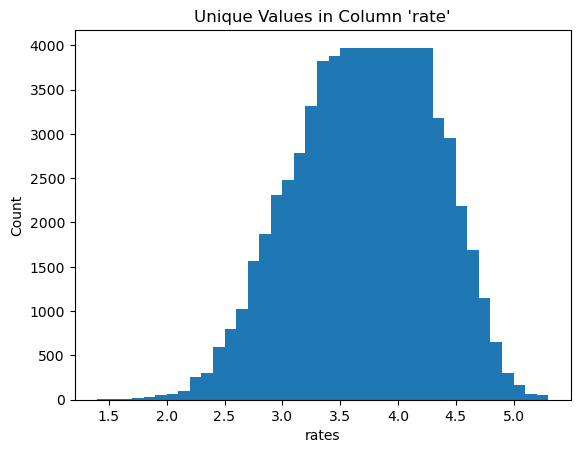

In [14]:
value_counts = df['rate'].value_counts() # Get the counts of each value in the column 'rate'


plt.bar(value_counts.index, value_counts.values)

# Set the title and axis labels
plt.title(f"Unique Values in Column '{'rate'}'")
plt.xlabel('rates')
plt.ylabel("Count")

# Show the plot
plt.show()

### we can put threshold in rate column 3.7 and predict the class is the restaurant rate > or < than 3.7


In [15]:
def label_encode(df):
    for col in df.columns[~df.columns.isin(['rate', 'approx_cost_2_people', 'votes'])]:
        df[col] = df[col].factorize()[0]
    return df

In [16]:
df_encoded = label_encode(df.copy())
df_encoded.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost_2_people,reviews_list,menu_item,listed_in_type,listed_in_city
0,0,0,0,0,4.1,775,0,0,0,0,800.0,0,0,0,0
1,1,1,0,1,4.1,787,0,0,1,1,800.0,1,0,0,0
2,2,2,0,1,3.8,918,0,1,2,2,800.0,2,0,0,0
3,3,3,1,1,3.7,88,0,2,3,3,300.0,3,0,0,0
4,4,4,1,1,3.8,166,1,0,4,4,600.0,4,0,0,0


# Exploratory data analysis (EDA)

In [17]:
target = df_encoded.rate.fillna(df_encoded.rate.mean()) # Filling nan values in target by mean

Text(0.5, 1.0, 'Target distribution')

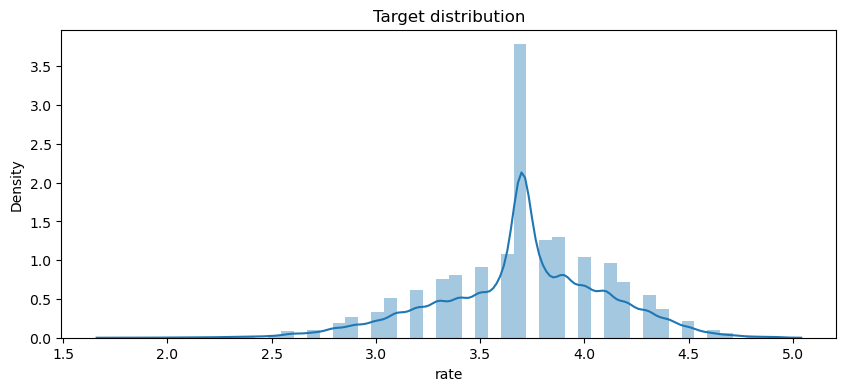

In [18]:
plt.figure(figsize=(10,4))
sns.distplot(target) # target is the rate column and this is the distribution of the target almost normal
plt.title('Target distribution')

From the figure above, we can see that the distribution of the rates is not uniform! We have restaurants we high rates while other have low.

In [19]:
def set_rating_flag(row):
    if row['rate'] > 3.9:
        return 1
    else:
        return 0

df_encoded_out = df_encoded.copy()
# Add a new column based on the function
df_encoded_out['output'] = df_encoded.apply(lambda row: set_rating_flag(row), axis=1)

In [20]:
df_encoded_out.head()

,address,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,approx_cost_2_people,reviews_list,menu_item,listed_in_type,listed_in_city,output
0,0,0,0,0,4.1,775,0,0,0,0,800.0,0,0,0,0,1
1,1,1,0,1,4.1,787,0,0,1,1,800.0,1,0,0,0,1
2,2,2,0,1,3.8,918,0,1,2,2,800.0,2,0,0,0,0
3,3,3,1,1,3.7,88,0,2,3,3,300.0,3,0,0,0,0
4,4,4,1,1,3.8,166,1,0,4,4,600.0,4,0,0,0,0


### Correlation between features.



In [21]:
corr = df_encoded.corr(method='kendall') # kendall since some of our features are ordinal.


<AxesSubplot:>

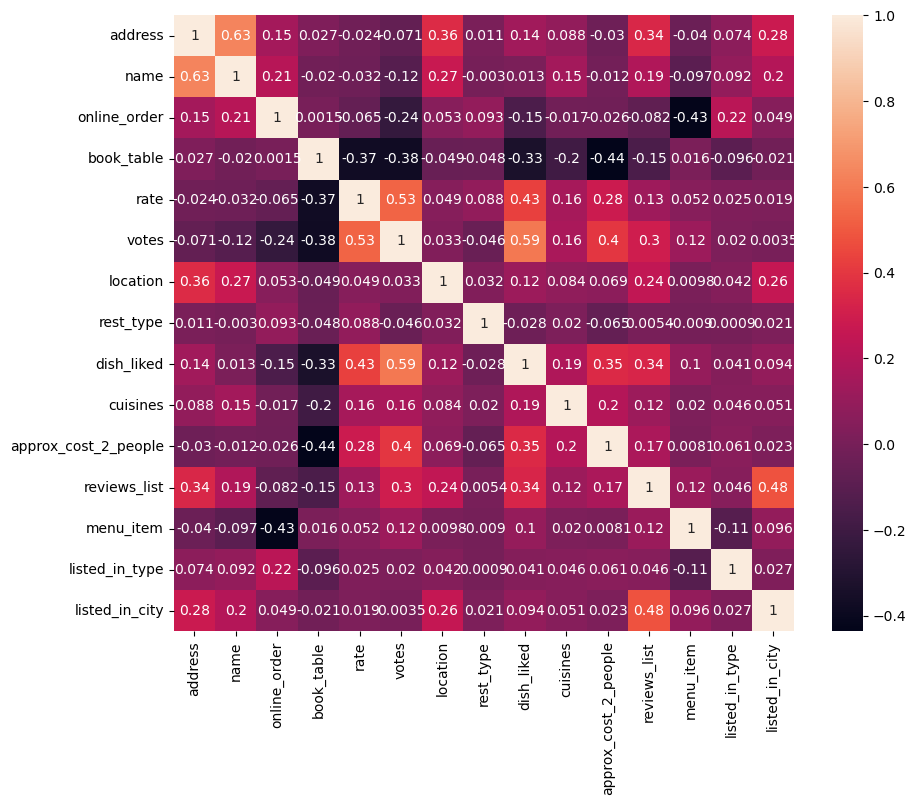

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)

From the heatmap, we can see that some variables are positively correlated and some other negatively. The highest correlation 0.63 is between name and address and the lowest -0.44 between book_table and approx_cost_2_people. Highly correlated features maybe imply redondant information. So we might drop one the them. The correlations that will interest us at this stage are between our target rate and the other features. The more a feature is correlated to the target (positively or negatively) the more it could help predicting the target. And from the plot, one can see that the 2 top positively correlated features to the target are dish_liked, vote. Which means the more a dish is liked and a restaurant receive higher votes the more the rate increase. One can also note from the plot that only one feature book_table is negatively correlated to the target. Which means that restaurant in which booking table is needed have low rate.

In [23]:
histo = df.groupby('name')['address'].count()
# Lets take the top 50 restaurantsand plot bar graph
histo = histo.sort_values()[-50:]

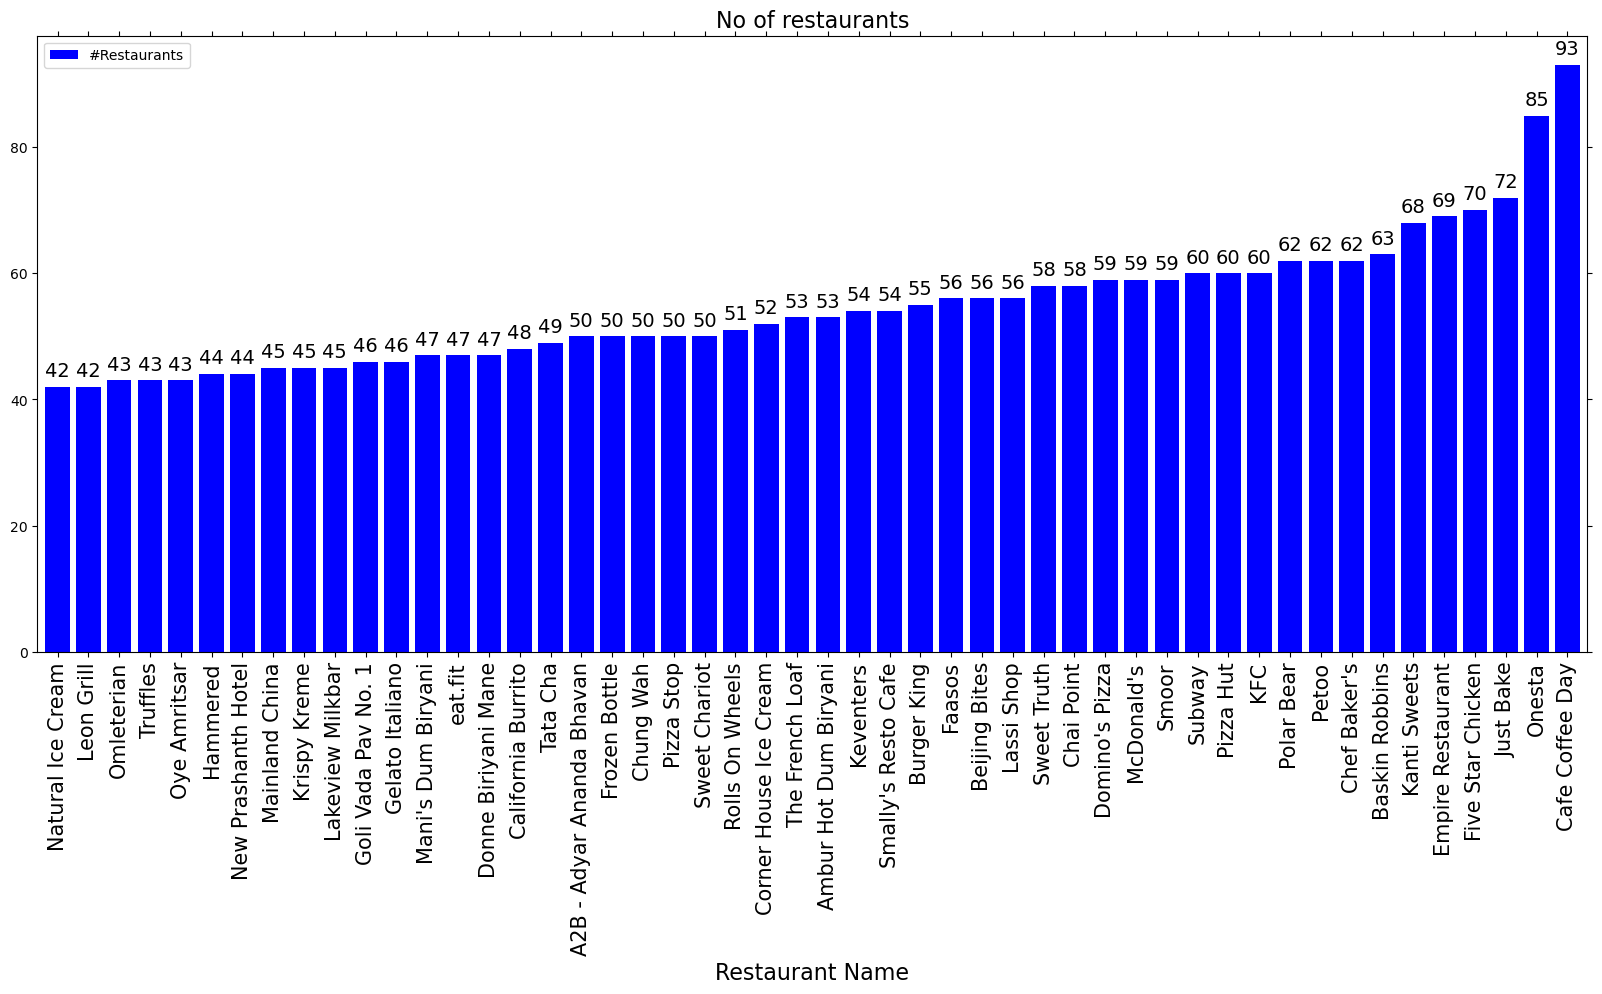

In [24]:
ax = histo.plot(kind='bar', figsize=(20, 8), rot=90, width = 0.8, color=[ 'blue'])
rects = ax.patches
labels = list(histo)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom', fontsize=14)
ax.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on') # remove borders
ax.xaxis.set_tick_params(labelsize=15) # set xticks as 14
ax.legend(fontsize=14) # set legend sie as 14
ax.set_title('No of restaurants', fontsize=16) # set title and add font size as 16
ax.set_xlabel('Restaurant Name', fontsize=16)
#ax.grid(False)  # remove grid
ax.set_facecolor("white") # set bg color white
ax.legend(['#Restaurants'])

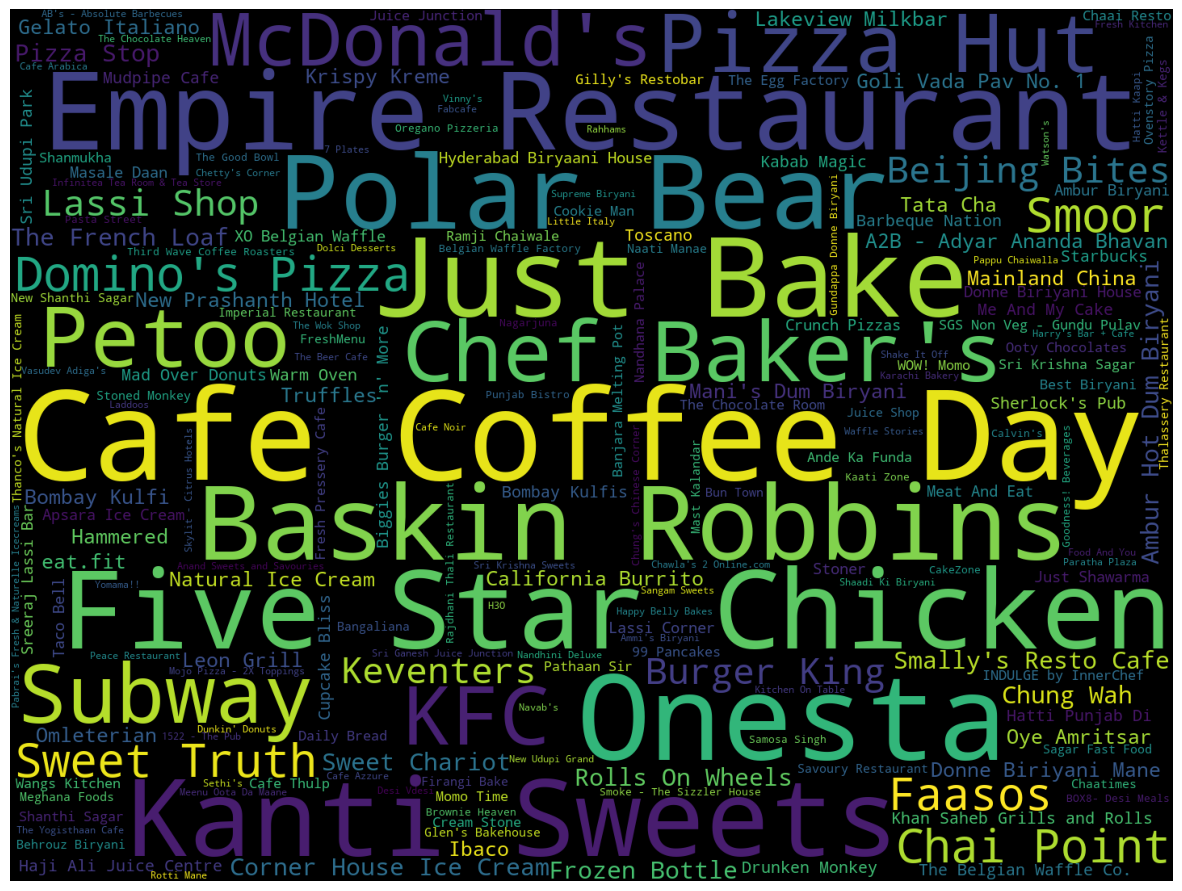

In [25]:
wordcloud = (WordCloud(width=1440, height=1080, relative_scaling=0.5).generate_from_frequencies(df['name'].value_counts()))


fig = plt.figure(1,figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Clearly CCD(Cafe) has the most number of restaurants in Bengaluru, followed by Onesta



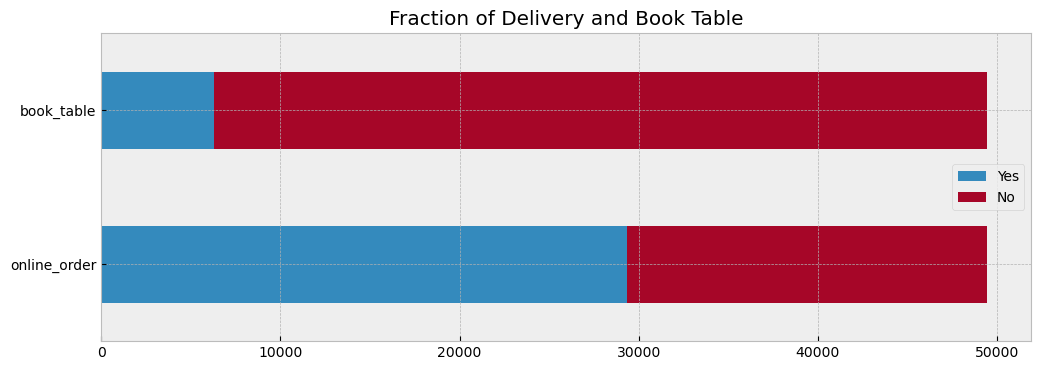

In [26]:
with plt.style.context('bmh', after_reset = True):
    plt.figure(figsize = (12,4))
    ax = plt.subplot(1,1,1)
    tmp = {}
    for col in ['online_order', 'book_table']: 
        tmp[col] = df[col].value_counts()
    tmp = pd.DataFrame.from_dict(tmp, orient = 'index')
    tmp.plot.barh(stacked = True, ax = ax)
    ax.set_title('Fraction of Delivery and Book Table')
    plt.show()

Checking restaurants that online ordering and not also book tables or not provide that

In [27]:

print('Features \t # unique values\n')
for col in list(df_encoded):
    print(f'{col}:\t     \t   {df_encoded[col].nunique()}')

Features 	 # unique values

address:	     	   11050
name:	     	   8458
online_order:	     	   2
book_table:	     	   2
rate:	     	   31
votes:	     	   2328
location:	     	   94
rest_type:	     	   94
dish_liked:	     	   5229
cuisines:	     	   2633
approx_cost_2_people:	     	   68
reviews_list:	     	   22070
menu_item:	     	   8784
listed_in_type:	     	   7
listed_in_city:	     	   30


In [28]:

x_train, x_test, y_train, y_test = train_test_split(df_encoded,df_encoded_out.output, test_size=0.33 ,random_state=42)


In [29]:
df_encoded.describe

<bound method NDFrame.describe of        address  name  online_order  book_table  rate  votes  location  \
0            0     0             0           0   4.1    775         0   
1            1     1             0           1   4.1    787         0   
2            2     2             0           1   3.8    918         0   
3            3     3             1           1   3.7     88         0   
4            4     4             1           1   3.8    166         1   
...        ...   ...           ...         ...   ...    ...       ...   
49435    10956  8390             1           1   3.6     27        29   
49436    10978  8395             1           1   NaN      0        29   
49437    10953  8457             1           1   NaN      0        29   
49438    11043  8453             1           0   4.3    236        62   
49439     4147  8454             1           1   3.4     13        62   

       rest_type  dish_liked  cuisines  approx_cost_2_people  reviews_list  \
0          

In [30]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49440 entries, 0 to 49439
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               49440 non-null  int64  
 1   name                  49440 non-null  int64  
 2   online_order          49440 non-null  int64  
 3   book_table            49440 non-null  int64  
 4   rate                  41665 non-null  float64
 5   votes                 49440 non-null  int64  
 6   location              49440 non-null  int64  
 7   rest_type             49440 non-null  int64  
 8   dish_liked            49440 non-null  int64  
 9   cuisines              49440 non-null  int64  
 10  approx_cost_2_people  49099 non-null  float64
 11  reviews_list          49440 non-null  int64  
 12  menu_item             49440 non-null  int64  
 13  listed_in_type        49440 non-null  int64  
 14  listed_in_city        49440 non-null  int64  
dtypes: float64(2), int6

In [31]:
df_encoded.isnull().sum()

address                    0
name                       0
online_order               0
book_table                 0
rate                    7775
votes                      0
location                   0
rest_type                  0
dish_liked                 0
cuisines                   0
approx_cost_2_people     341
reviews_list               0
menu_item                  0
listed_in_type             0
listed_in_city             0
dtype: int64

In [32]:
# drop NaN values from the dataset
df_encoded = df_encoded.dropna()





In [33]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41418 entries, 0 to 49439
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               41418 non-null  int64  
 1   name                  41418 non-null  int64  
 2   online_order          41418 non-null  int64  
 3   book_table            41418 non-null  int64  
 4   rate                  41418 non-null  float64
 5   votes                 41418 non-null  int64  
 6   location              41418 non-null  int64  
 7   rest_type             41418 non-null  int64  
 8   dish_liked            41418 non-null  int64  
 9   cuisines              41418 non-null  int64  
 10  approx_cost_2_people  41418 non-null  float64
 11  reviews_list          41418 non-null  int64  
 12  menu_item             41418 non-null  int64  
 13  listed_in_type        41418 non-null  int64  
 14  listed_in_city        41418 non-null  int64  
dtypes: float64(2), int6

In [34]:
spark = SparkSession.builder \
    .appName("NB") \
    .config("spark.driver.memory", "15g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
sc=spark.sparkContext

spark_df = spark.createDataFrame(df_encoded_out)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/15 13:56:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [35]:
spark_df.show(5)

+-------+----+------------+----------+----+-----+--------+---------+----------+--------+--------------------+------------+---------+--------------+--------------+------+
|address|name|online_order|book_table|rate|votes|location|rest_type|dish_liked|cuisines|approx_cost_2_people|reviews_list|menu_item|listed_in_type|listed_in_city|output|
+-------+----+------------+----------+----+-----+--------+---------+----------+--------+--------------------+------------+---------+--------------+--------------+------+
|      0|   0|           0|         0| 4.1|  775|       0|        0|         0|       0|               800.0|           0|        0|             0|             0|     1|
|      1|   1|           0|         1| 4.1|  787|       0|        0|         1|       1|               800.0|           1|        0|             0|             0|     1|
|      2|   2|           0|         1| 3.8|  918|       0|        1|         2|       2|               800.0|           2|        0|             0|   

In [36]:
# drop the columns which are not required
spark_df = spark_df.drop('rest_type', 'location','dish_liked' , 'cuisines' , 'reviews_list' , 'menu_item' , 'listed_in_type' , 'listed_in_city', 'address' , 'name','url', 'phone','online_order' , 'book_table')


In [37]:
spark_df.show(5)

+----+-----+--------------------+------+
|rate|votes|approx_cost_2_people|output|
+----+-----+--------------------+------+
| 4.1|  775|               800.0|     1|
| 4.1|  787|               800.0|     1|
| 3.8|  918|               800.0|     0|
| 3.7|   88|               300.0|     0|
| 3.8|  166|               600.0|     0|
+----+-----+--------------------+------+
only showing top 5 rows



<AxesSubplot:>

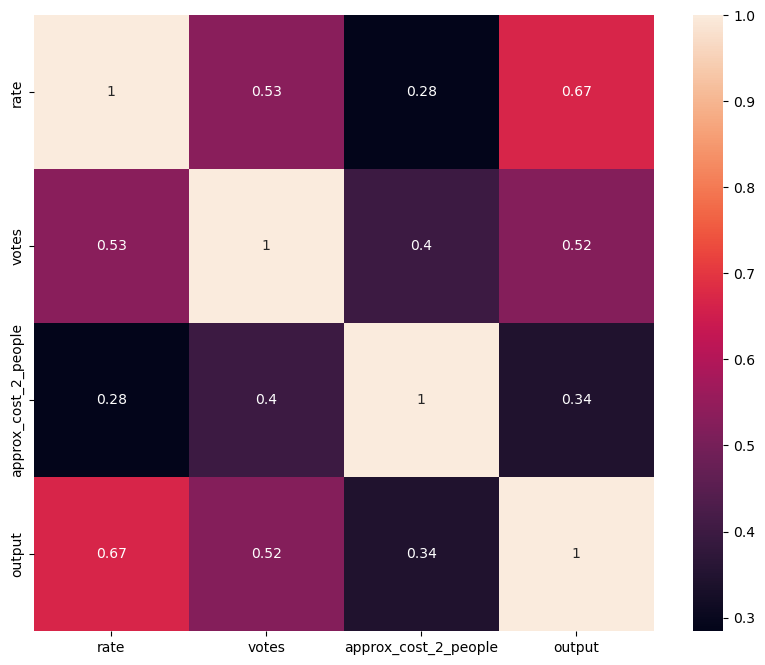

In [38]:
corr_df = spark_df.toPandas()
corr = corr_df.corr(method='kendall') # kendall since some of our features are ordinal.

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True)

#### I will take the features which are highly correlated with the target variable
#### which are votes, dish_liked, approx_cost_2_people, reviews_list

In [39]:
spark_df = spark_df.select(["votes", "approx_cost_2_people", "output"])

In [40]:
spark_df.show(5)

+-----+--------------------+------+
|votes|approx_cost_2_people|output|
+-----+--------------------+------+
|  775|               800.0|     1|
|  787|               800.0|     1|
|  918|               800.0|     0|
|   88|               300.0|     0|
|  166|               600.0|     0|
+-----+--------------------+------+
only showing top 5 rows



In [41]:
# remove the negative values from cpark_df columns
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

def remove_negative(x):
    if x < 0:
        return 0
    else:
        return x
    
remove_negative_udf = udf(lambda x: remove_negative(x) , IntegerType())

spark_df = spark_df.withColumn("votes", remove_negative_udf(col("votes")))



In [42]:
spark_df = spark_df.fillna({'votes': 0, 'approx_cost_2_people': 0})


In [43]:
spark_df = spark_df.withColumn('votes', spark_df['votes'].cast(DoubleType()))
spark_df = spark_df.withColumn('approx_cost_2_people', spark_df['approx_cost_2_people'].cast(DoubleType()))


In [44]:
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()


+-----+--------------------+------+
|votes|approx_cost_2_people|output|
+-----+--------------------+------+
|    0|                   0|     0|
+-----+--------------------+------+



In [45]:
spark_df.show(5)

+-----+--------------------+------+
|votes|approx_cost_2_people|output|
+-----+--------------------+------+
|775.0|               800.0|     1|
|787.0|               800.0|     1|
|918.0|               800.0|     0|
| 88.0|               300.0|     0|
|166.0|               600.0|     0|
+-----+--------------------+------+
only showing top 5 rows



# Model without map reduce

In [46]:
(training_data, test_data) = spark_df.randomSplit([0.7, 0.3], seed=42)
features = ['votes', 'approx_cost_2_people']
label = 'output'



In [47]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
training_data = assembler.transform(training_data)
test_data = assembler.transform(test_data)

In [48]:

nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol=label, featuresCol="features")


In [49]:
model = nb.fit(training_data)


In [50]:
predictions = model.transform(test_data)
predictions.select("prediction", label).show(10)


evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Model without map-reduce accuracy:", accuracy)


23/05/15 13:56:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+----------+------+
|prediction|output|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 10 rows



Model without map-reduce accuracy: 0.8297596285167987


# Model with map-reduce

In [51]:
# map function to convert the data into tuples

class NB: 
    def __init__(self):
        self.frequencyTable = None

    def mapFunction(self, row):

        # Extract the features and target from the row 
        features = row[:-1]
        target = row[-1]

        # Create a list of dictionary to save the feature index, value, target, and add 1 to each value to use  it in reduce step
        map = []
        print (features , target , "\n")

        # Loop through each feature index and value
        for i, x in enumerate(features):
            # Append a tuple of feature index, value, target, and count to the list
            map.append(((i, x, target), 1))

        # Return the list of dictionary
        return map

    def reduceFunction(self, x, y):
        # Return the sum of x and y
        return x + y
    
    def predict(self, row, frequencyTablebroadCast, test=False):
        freqTable = frequencyTablebroadCast.value
        # Extract the features and target from the line
        features = row[:-1]
        if test:
            target = int(row[-1])

        # Posterior probabilities for the target classes
        posteriors = []

        # Loop through each class label that is 0 or 1 in our dataset
        for label in [0, 1]:
            # Initialize the posterior probability as the prior probability of the class label with Laplace smoothing
            posterior = (freqTable[('total', label)] + 1) / (freqTable[('total', 'train')] + 2)

            # Loop through each feature index and value
            for i, feat in enumerate(features):
                feat = float(feat)
                try:
                    # Update the posterior probability with the likelihood of the feature value given the class label with Laplace smoothing
                    posterior *= (freqTable[(i, feat, label)] + 1) / (freqTable[('total', label)] + len(freqTable)) # likelihood * prior
                except:
                    # If the feature value given the class label is not found in the frequency table, set the likelihood to 0
                    posterior *= (0 + 1) / (freqTable[('total', label)] + len(freqTable)) # likelihood * prior 

            # Save the posterior probability for the class label to the list
            posteriors.append(posterior)

        # Get the predicted class label by finding the class label with the largest posterior probability
        prediction = np.argmax(posteriors)

        if test:
            # finally return the tuple of target and prediction
            return (float(target), float(prediction))
        else:
            # finally return the prediction
            return (float(prediction))
    
    

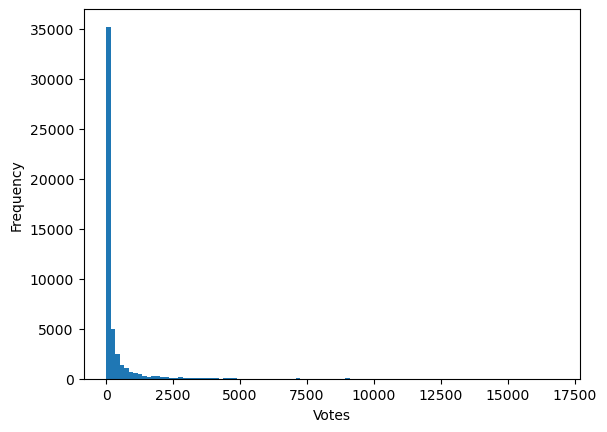

In [52]:
# plot the votes values to see the distribution
plt.hist(df_encoded_out['votes'], bins=100)
# put name on the x-axis
plt.xlabel('Votes')
# put name on the y-axis
plt.ylabel('Frequency')
plt.show()

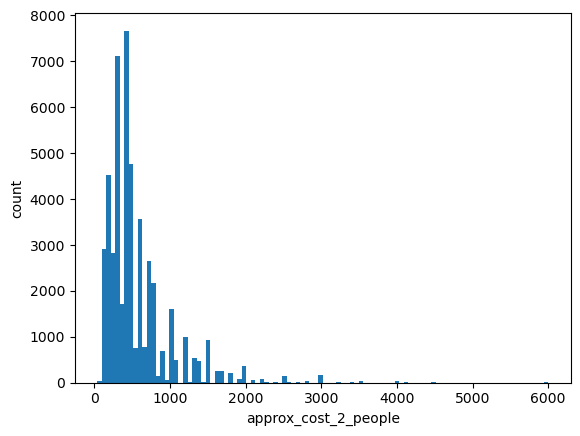

In [63]:
# see the distribution of approx_cost_2_people
plt.hist(df_encoded_out['approx_cost_2_people'], bins=100)
# put name on the x-axis
plt.xlabel('approx_cost_2_people')
# put name on the y-axis
plt.ylabel('count')
plt.show()

#### Non of the variable follow gausian distribution so we can not use meas and stander deviation to represent this distribution and use it in naive bayes classifier
#### so i will use Multinomial Naive Bayes  


In [54]:
# split the data into train and test
train, test = spark_df.randomSplit([0.7, 0.3], seed=12345)
train = train.rdd
test = test.rdd

In [55]:
# Create an instance of the NB class as model
model = NB()

In [56]:
# Apply the map function to the data RDD
mappedRdd = train.flatMap(model.mapFunction)


In [57]:
# Sum the counts for each tuple
reducedRdd = mappedRdd.reduceByKey(model.reduceFunction) 


In [58]:
# Collect the frequency table as a dictionary
model.frequencyTable = reducedRdd.collectAsMap()

(0.0, 0.0) 0                                                        (0 + 8) / 8]

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 0.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 100.0) 0 

(0.0, 120.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 0.0)(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0)  0 

0 (0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 


(0.0, 150.0) 0
(0.0, 0.0) 0 

(0.0, 0.0) 0 

 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0) 0 

(0.0, 150.0

# Naive Bayes with laplace smothing
<img src="https://qph.cf2.quoracdn.net/main-qimg-b6736b7224ff76ac834205c019c96e6b" width="50%" height="30%">


In [59]:
# Add a ('total , 'train) key-value pair to save the total n_records to the frequency_table dictionary
model.frequencyTable[('total', 'train')] = train.count()

# Add another  ('total , 0) and ('total , 1) key-value pair to save the total n_records with class label 0 and 1 to the frequency_table dictionary
model.frequencyTable[('total', 0)] = train.filter(lambda row: row.output == 0).count() # this is the number of records with class output 0
model.frequencyTable[('total', 1)] = train.filter(lambda row: row.output == 1).count() # this is the number of records with class output 1

# Broadcast the frequency_table dictionary to the workers as a read-only variable (clusters of data)
bcast = spark.sparkContext.broadcast(model.frequencyTable) 

# By using test data, predict the class label for each record in the test RDD
predictions = test.map(lambda row: model.predict(row, bcast , True))

# MulticlassClassificationEvaluator expects the true and predicted labels in a DataFrame to 
evaluator = MulticlassClassificationEvaluator(labelCol="trueLabel", predictionCol="predictedLabel", metricName="accuracy")

# Define the schema of the predictions DataFrame
schema = StructType([
  StructField("trueLabel", DoubleType(), True),
  StructField("predictedLabel", DoubleType(), True)
])

In [60]:
# Create a DataFrame from the predictions RDD
predictions = predictions.toDF(schema=schema)
accuracy = evaluator.evaluate(predictions)
print(f"Model with map-reduce accuracy = {accuracy}")



Model with map-reduce accuracy = 0.8616728249916022


In [61]:
# predict new data that will predict 0 not 1

new_data = spark.createDataFrame(pd.DataFrame({'votes': [300] ,'approx_cost_2_people': [400]})) # 600,1000 votes and 500 cost = 1
                                                                                                # 48 , 300 votes and 400 cost = 0
new_data.show()
new_data = new_data.rdd
predictions = new_data.map(lambda row: model.predict(row, bcast , False))
predictions.collect()


+-----+--------------------+
|votes|approx_cost_2_people|
+-----+--------------------+
|  300|                 400|
+-----+--------------------+



[0.0]